# Gradient Boosting Classifier


## Pull and Clean Datasets

In [1]:
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

In [4]:
df_train = pd.read_csv('Data/hate_speech_training.csv')
df_train_2 = pd.read_csv('Data/hate_speech_training_2.csv')
df_train_3 = pd.read_csv('Data/hate_speech_training_3.csv')
df_train_4 = pd.read_csv('Data/hate_speech_training_4.tsv', sep = '\t')
df_train_5 = pd.read_csv('Data/hate_speech_training_5.csv')

In [5]:
df_train = df_train.drop('id', axis = 1) #0 = Not Hate Speech, 1 = Hate Speech

In [6]:
df_train_2 = df_train_2[['tweet', 'class']]
df_train_2['class'] = df_train_2['class'].replace([0], 'hate speech')
df_train_2['class'] = df_train_2['class'].replace([1, 2], 'not hate speech')
df_train_2['class'] = df_train_2['class'].replace(['hate speech'], 1)
df_train_2['class'] = df_train_2['class'].replace(['not hate speech'], 0)
df_train_2.rename(columns = {'class': 'label'}, inplace = True) #0 = Not Hate Speech, 1 = Hate Speech

In [7]:
df_train_3 = df_train_3.drop('index', axis = 1) 
df_train_3.rename(columns = {'post': 'tweet'}, inplace = True) #0 = Not Hate Speech, 1 = Hate Speech

In [8]:
df_train_4 = df_train_4[['text', 'HS']] 
df_train_4.rename(columns = {'text': 'tweet', 'HS': 'label'}, inplace = True) #0 = Not Hate Speech, 1 = Hate Speech

In [9]:
df_train_5['Label'] = df_train_5['Label'].replace(['Hate', 'Non-Asian Aggression'], 1)
df_train_5['Label'] = df_train_5['Label'].replace(['Neutral', 'Counterhate'], 0) 
df_train_5.rename(columns = {'Text': 'tweet', 'Label': 'label'}, inplace = True) #0 = Not Hate Speech, 1 = Hate Speech

In [10]:
dfs = [df_train, df_train_2, df_train_3, df_train_4, df_train_5]
df = pd.concat(dfs)

## Train, Test, Split

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
X = df['tweet']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=3,
                                                    test_size=0.20,
                                                   stratify = y) #80/20 split

## NLP Cleaning

In [13]:
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer

In [14]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/christopherdelacruz/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [15]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/christopherdelacruz/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [16]:
sw = stopwords.words('english')
sw_add = ['@user', '#', '@', 'https', 'amp', 'co', 
          'http', 'RT', '#','##','####','######','##########','##@user']
sw = sw + sw_add

In [17]:
def get_wordnet_pos(treebank_tag):
    
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [18]:
def doc_preparer(doc, stop_words=sw):
 
    regex_token = RegexpTokenizer(r"([@#a-zA-Z]+(?:’[a-z]+)?)")
    doc = regex_token.tokenize(doc)
    doc = [word.lower() for word in doc]
    doc = [word for word in doc if word not in sw]
    doc = pos_tag(doc)
    doc = [(word[0], get_wordnet_pos(word[1])) for word in doc]
    lemmatizer = WordNetLemmatizer() 
    doc = [lemmatizer.lemmatize(word[0], word[1]) for word in doc]
    return ' '.join(doc)

In [19]:
token_docs = [doc_preparer(doc, sw) for doc in X_train]
test_token_docs = [doc_preparer(doc, sw) for doc in X_test]

## Pipeline for TF-IDF on Gradient Boosting with Classes 50/50

In [20]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [21]:
tfidf_gbc_pipe = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('SMOTE', SMOTE(n_jobs = -1)),
    ('gbc', GradientBoostingClassifier())
])

In [22]:
tfidf_gbc_pipe.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('SMOTE', SMOTE(n_jobs=-1)),
                ('gbc', GradientBoostingClassifier())])

In [21]:
tfidf_gbc_pipe.score(X_train, y_train)

0.8920953121890323

In [23]:
from sklearn.model_selection import cross_val_score

In [24]:
cross_val_score(tfidf_gbc_pipe, X_train, y_train, scoring = 'precision', cv = 5)

array([0.38672986, 0.37843337, 0.39368421, 0.39166667, 0.4172043 ])

In [22]:
tfidf_gbc_pipe.score(X_test, y_test)

0.8949920393689391

In [25]:
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, classification_report

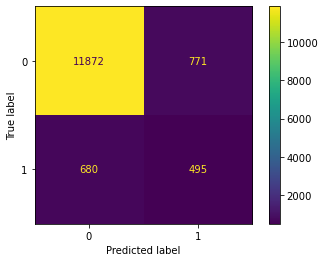

In [24]:
plot_confusion_matrix(tfidf_gbc_pipe, X_test, y_test)

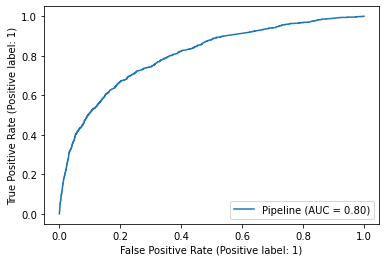

In [25]:
plot_roc_curve(tfidf_gbc_pipe, X_test, y_test)

In [42]:
y_hat = tfidf_gbc_pipe.predict(test_token_docs)
print(classification_report(y_pred = y_hat, y_true = y_test))

              precision    recall  f1-score   support

           0       0.93      0.98      0.96     12643
           1       0.53      0.24      0.33      1175

    accuracy                           0.92     13818
   macro avg       0.73      0.61      0.64     13818
weighted avg       0.90      0.92      0.90     13818



## Pipeline for TF-IDF on Gradient Boosting with Classes 75/25

In [26]:
tfidf_75_gbc_pipe = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('SMOTE', SMOTE(n_jobs = -1, sampling_strategy = 0.75)),
    ('gbc', GradientBoostingClassifier())
])

In [27]:
tfidf_75_gbc_pipe.fit(token_docs, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('SMOTE', SMOTE(n_jobs=-1, sampling_strategy=0.75)),
                ('gbc', GradientBoostingClassifier())])

In [38]:
tfidf_75_gbc_pipe.score(token_docs, y_train)

0.9058095565486421

In [28]:
cross_val_score(tfidf_75_gbc_pipe, token_docs, y_train, scoring = 'precision', cv = 5)

array([0.44890511, 0.42843866, 0.43207547, 0.43082637, 0.45082765])

In [39]:
tfidf_75_gbc_pipe.score(test_token_docs, y_test)

0.9062816616008106

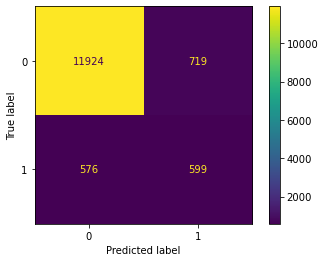

In [40]:
plot_confusion_matrix(tfidf_75_gbc_pipe, test_token_docs, y_test)

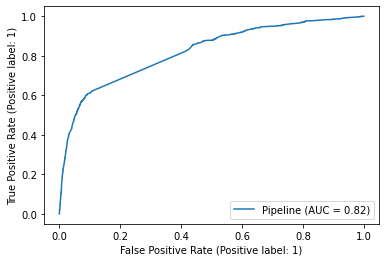

In [41]:
plot_roc_curve(tfidf_75_gbc_pipe, test_token_docs, y_test)

In [43]:
y_hat_2 = tfidf_75_gbc_pipe.predict(test_token_docs)
print(classification_report(y_pred = y_hat_2, y_true =y_test))

              precision    recall  f1-score   support

           0       0.95      0.94      0.95     12643
           1       0.45      0.51      0.48      1175

    accuracy                           0.91     13818
   macro avg       0.70      0.73      0.71     13818
weighted avg       0.91      0.91      0.91     13818



## Pipeline for TF-IDF on Gradient Boosting with Classes 90/10

In [29]:
tfidf_90_gbc_pipe = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('SMOTE', SMOTE(n_jobs = -1, sampling_strategy = 0.90)),
    ('gbc', GradientBoostingClassifier())
])

In [30]:
tfidf_90_gbc_pipe.fit(token_docs, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('SMOTE', SMOTE(n_jobs=-1, sampling_strategy=0.9)),
                ('gbc', GradientBoostingClassifier())])

In [46]:
tfidf_90_gbc_pipe.score(token_docs, y_train)

0.8974145573628123

In [31]:
cross_val_score(tfidf_90_gbc_pipe, token_docs, y_train, scoring = 'precision', cv = 5)

array([0.41877551, 0.41913633, 0.41659681, 0.41858483, 0.43639576])

In [47]:
tfidf_90_gbc_pipe.score(test_token_docs, y_test)

0.9018671298306556

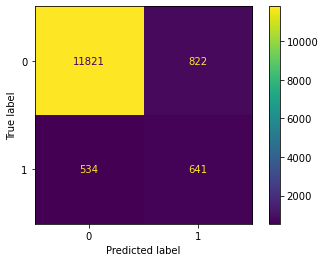

In [48]:
plot_confusion_matrix(tfidf_90_gbc_pipe, test_token_docs, y_test)

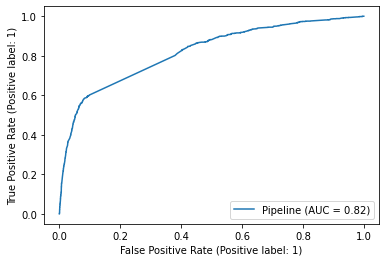

In [49]:
plot_roc_curve(tfidf_90_gbc_pipe, test_token_docs, y_test)

In [50]:
y_hat_3 = tfidf_90_gbc_pipe.predict(test_token_docs)
print(classification_report(y_pred = y_hat_3, y_true = y_test))

              precision    recall  f1-score   support

           0       0.96      0.93      0.95     12643
           1       0.44      0.55      0.49      1175

    accuracy                           0.90     13818
   macro avg       0.70      0.74      0.72     13818
weighted avg       0.91      0.90      0.91     13818



## Pipeline for Count Vectorizer on Gradient Boosting with Classes Balanced

In [32]:
cv_gbc_pipe = Pipeline([
    ('cv', CountVectorizer()),
    ('SMOTE', SMOTE(n_jobs = -1)),
    ('gbc', GradientBoostingClassifier())
])

In [33]:
cv_gbc_pipe.fit(token_docs, y_train)

Pipeline(steps=[('cv', CountVectorizer()), ('SMOTE', SMOTE(n_jobs=-1)),
                ('gbc', GradientBoostingClassifier())])

In [53]:
cv_gbc_pipe.score(token_docs, y_train)

0.6617213366865083

In [34]:
cross_val_score(cv_gbc_pipe, token_docs, y_train, scoring = 'precision', cv = 5)

array([0.14701636, 0.16248078, 0.15775136, 0.15563464, 0.15160494])

In [54]:
cv_gbc_pipe.score(test_token_docs, y_test)

0.6597915762049501

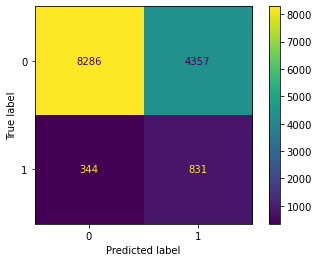

In [55]:
plot_confusion_matrix(cv_gbc_pipe, test_token_docs, y_test)

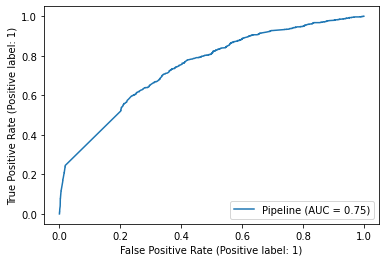

In [56]:
plot_roc_curve(cv_gbc_pipe, test_token_docs, y_test)

In [57]:
y_hat_4 = cv_gbc_pipe.predict(test_token_docs)
print(classification_report(y_pred = y_hat_4, y_true = y_test))

              precision    recall  f1-score   support

           0       0.96      0.66      0.78     12643
           1       0.16      0.71      0.26      1175

    accuracy                           0.66     13818
   macro avg       0.56      0.68      0.52     13818
weighted avg       0.89      0.66      0.73     13818



## Pipeline for Count Vectorizer on Gradient Boosting with Classes Balanced 75/25

In [35]:
cv_75_gbc_pipe = Pipeline([
    ('cv', CountVectorizer()),
    ('SMOTE', SMOTE(n_jobs = -1, sampling_strategy = 0.75)),
    ('gbc', GradientBoostingClassifier())
])

In [36]:
cv_75_gbc_pipe.fit(token_docs, y_train)

Pipeline(steps=[('cv', CountVectorizer()),
                ('SMOTE', SMOTE(n_jobs=-1, sampling_strategy=0.75)),
                ('gbc', GradientBoostingClassifier())])

In [60]:
cv_75_gbc_pipe.score(token_docs, y_train)

0.7328617177181523

In [37]:
cross_val_score(cv_75_gbc_pipe, token_docs, y_train, scoring = 'precision', cv = 5)

array([0.16917539, 0.18094945, 0.18287938, 0.17652495, 0.17198637])

In [61]:
cv_75_gbc_pipe.score(test_token_docs, y_test)

0.734259661311333

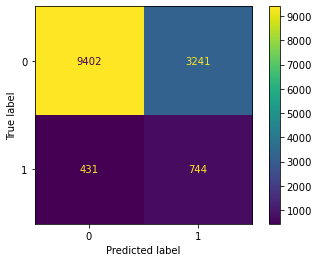

In [62]:
plot_confusion_matrix(cv_75_gbc_pipe, test_token_docs, y_test)

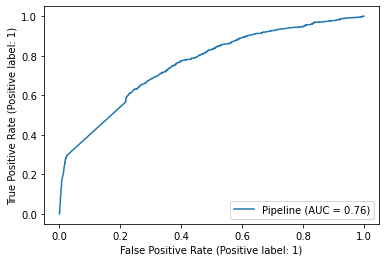

In [63]:
plot_roc_curve(cv_75_gbc_pipe, test_token_docs, y_test)

In [64]:
y_hat_5 = cv_75_gbc_pipe.predict(test_token_docs)
print(classification_report(y_pred = y_hat_5, y_true = y_test))

              precision    recall  f1-score   support

           0       0.96      0.74      0.84     12643
           1       0.19      0.63      0.29      1175

    accuracy                           0.73     13818
   macro avg       0.57      0.69      0.56     13818
weighted avg       0.89      0.73      0.79     13818



## Pipeline for Count Vectorizer on Gradient Boosting with Classes Balanced 90/10

In [38]:
cv_90_gbc_pipe = Pipeline([
    ('cv', CountVectorizer()),
    ('SMOTE', SMOTE(n_jobs = -1, sampling_strategy = 0.9)),
    ('gbc', GradientBoostingClassifier())
])

In [39]:
cv_90_gbc_pipe.fit(token_docs, y_train)

Pipeline(steps=[('cv', CountVectorizer()),
                ('SMOTE', SMOTE(n_jobs=-1, sampling_strategy=0.9)),
                ('gbc', GradientBoostingClassifier())])

In [67]:
cv_90_gbc_pipe.score(token_docs, y_train)

0.6831068734055834

In [40]:
cross_val_score(cv_90_gbc_pipe, token_docs, y_train, scoring = 'precision', cv = 5)

array([0.15436415, 0.16810705, 0.16424226, 0.16328626, 0.15943194])

In [69]:
cv_90_gbc_pipe.score(test_token_docs, y_test)

0.6809958025763497

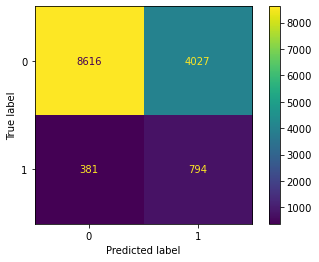

In [70]:
plot_confusion_matrix(cv_90_gbc_pipe, test_token_docs, y_test)

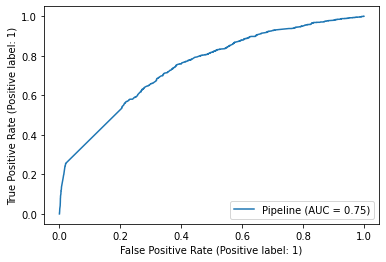

In [71]:
plot_roc_curve(cv_90_gbc_pipe, test_token_docs, y_test)

In [73]:
y_hat_6 = cv_90_gbc_pipe.predict(test_token_docs)
print(classification_report(y_pred = y_hat_6, y_true = y_test))

              precision    recall  f1-score   support

           0       0.96      0.68      0.80     12643
           1       0.16      0.68      0.26      1175

    accuracy                           0.68     13818
   macro avg       0.56      0.68      0.53     13818
weighted avg       0.89      0.68      0.75     13818



## NLP Cleanup Words Only (No # or @)

In [41]:
def doc_preparer_2(doc, stop_words=sw):
 
    regex_token = RegexpTokenizer(r"([a-zA-Z]+(?:’[a-z]+)?)")
    doc = regex_token.tokenize(doc)
    doc = [word.lower() for word in doc]
    doc = [word for word in doc if word not in sw]
    doc = pos_tag(doc)
    doc = [(word[0], get_wordnet_pos(word[1])) for word in doc]
    lemmatizer = WordNetLemmatizer() 
    doc = [lemmatizer.lemmatize(word[0], word[1]) for word in doc]
    return ' '.join(doc)

In [42]:
token_docs_2 = [doc_preparer_2(doc, sw) for doc in X_train]
test_token_docs_2 = [doc_preparer_2(doc, sw) for doc in X_test]

## TFIDF / GB / Different Classes

In [43]:
class_balances = ['auto', 0.75, 0.9]

For Class: auto
Training Score = 0.8919324781531002
Cross-Val Scores = [0.38467101 0.37547601 0.38648861 0.40224359 0.42665549]
Testing Score = 0.8926038500506586
              precision    recall  f1-score   support

           0       0.96      0.92      0.94     12643
           1       0.40      0.56      0.47      1175

    accuracy                           0.89     13818
   macro avg       0.68      0.74      0.70     13818
weighted avg       0.91      0.89      0.90     13818

---------------------------------------------------------
For Class: 0.75
Training Score = 0.9043621428959129
Cross-Val Scores = [0.41827768 0.40565178 0.43559489 0.43403442 0.44784689]
Testing Score = 0.9080908959328412
              precision    recall  f1-score   support

           0       0.95      0.95      0.95     12643
           1       0.46      0.51      0.49      1175

    accuracy                           0.91     13818
   macro avg       0.71      0.73      0.72     13818
weighted avg     

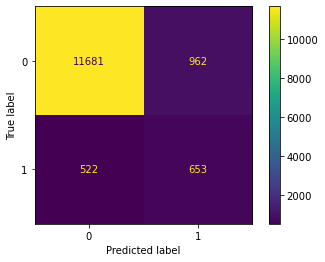

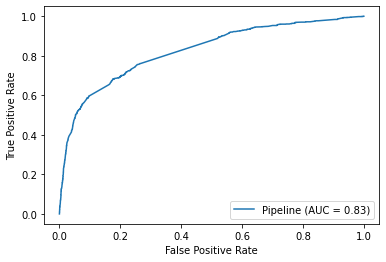

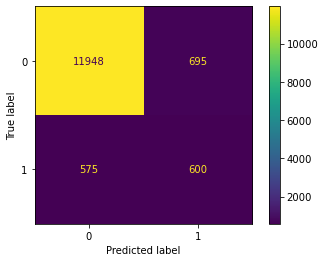

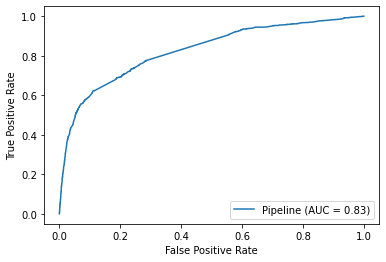

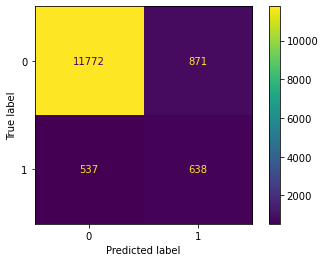

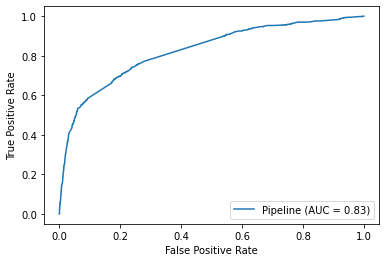

In [44]:
for balance in class_balances:
    tfidf_gb_pipe_2 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('SMOTE', SMOTE(n_jobs = -1, sampling_strategy = balance)),
    ('gb', GradientBoostingClassifier())
])
    tfidf_gb_pipe_2.fit(token_docs_2, y_train)
    print(f"For Class: {balance}")
    print(f"Training Score = {tfidf_gb_pipe_2.score(token_docs_2, y_train)}")
    print(f"Cross-Val Scores = {cross_val_score(tfidf_gb_pipe_2, token_docs_2, y_train, scoring = 'precision', cv = 5)}")
    print(f"Testing Score = {tfidf_gb_pipe_2.score(test_token_docs_2, y_test)}")
    plot_confusion_matrix(tfidf_gb_pipe_2, test_token_docs_2, y_test)
    plot_roc_curve(tfidf_gb_pipe_2, test_token_docs_2, y_test)
    y_hat_7 = tfidf_gb_pipe_2.predict(test_token_docs_2)
    print(classification_report(y_pred = y_hat_7, y_true = y_test))
    print("---------------------------------------------------------")

## CV / GB / Different Classes

For Class: auto
Training Score = 0.6694107217166326
Cross-Val Scores = [0.14913772 0.16461981 0.16006927 0.16095808 0.15411043]
Testing Score = 0.6666666666666666
              precision    recall  f1-score   support

           0       0.96      0.66      0.78     12643
           1       0.16      0.70      0.26      1175

    accuracy                           0.67     13818
   macro avg       0.56      0.68      0.52     13818
weighted avg       0.89      0.67      0.74     13818

---------------------------------------------------------
For Class: 0.75
Training Score = 0.74559895786217
Cross-Val Scores = [0.16952381 0.18735284 0.18512556 0.17956753 0.17181037]
Testing Score = 0.7471414097553916
              precision    recall  f1-score   support

           0       0.96      0.76      0.85     12643
           1       0.19      0.62      0.30      1175

    accuracy                           0.75     13818
   macro avg       0.57      0.69      0.57     13818
weighted avg       

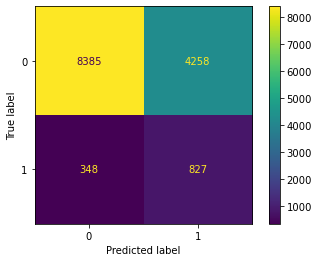

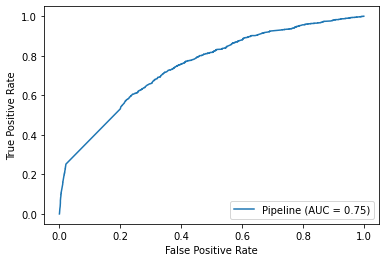

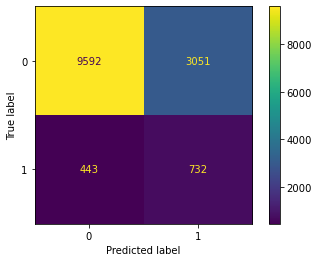

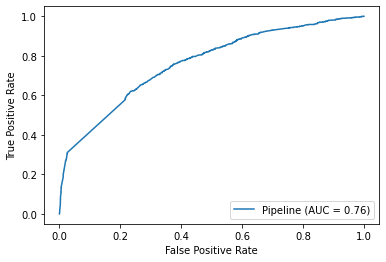

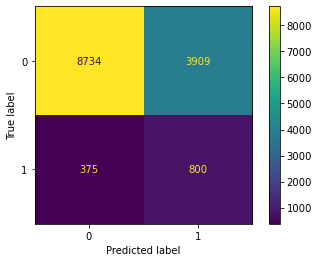

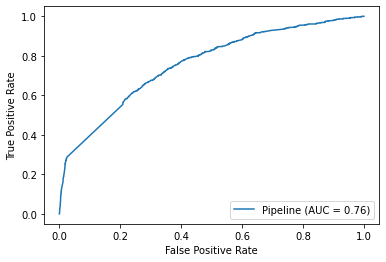

In [45]:
for balance in class_balances:
    cv_gb_pipe_2 = Pipeline([
    ('cv', CountVectorizer()),
    ('SMOTE', SMOTE(n_jobs = -1, sampling_strategy = balance)),
    ('gb', GradientBoostingClassifier())
])
    cv_gb_pipe_2.fit(token_docs_2, y_train)
    print(f"For Class: {balance}")
    print(f"Training Score = {cv_gb_pipe_2.score(token_docs_2, y_train)}")
    print(f"Cross-Val Scores = {cross_val_score(cv_gb_pipe_2, token_docs_2, y_train, scoring = 'precision', cv = 5)}")
    print(f"Testing Score = {cv_gb_pipe_2.score(test_token_docs_2, y_test)}")
    plot_confusion_matrix(cv_gb_pipe_2, test_token_docs_2, y_test)
    plot_roc_curve(cv_gb_pipe_2, test_token_docs_2, y_test)
    y_hat_8 = cv_gb_pipe_2.predict(test_token_docs_2)
    print(classification_report(y_pred = y_hat_8, y_true = y_test))
    print("---------------------------------------------------------")